In [235]:
from matplotlib import pyplot
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager, rc
import plotly.graph_objs as go 
import plotly.offline as py 
import plotly.express as px
import plotly.io as pio
import pandas as pd
import numpy as np

In [247]:
#data = pd.read_csv("PatientInfo.csv")
data = pd.read_csv("/content/drive/My Drive/응통 분석 공모전/데이터/코로나/일별확진자수.csv", encoding = 'euc-kr', header = 3)

In [248]:
data.head(3)

,시점,부산,광주,강원
0,2020. 03. 02,3,0,8
1,2020. 03. 04,3,2,1
2,2020. 03. 05,-1,1,2


In [253]:
# 필요한 칼럼만 확인 
kw_data = data[['시점','강원']]

In [254]:
kw_data.head()

,시점,강원
0,2020. 03. 02,8
1,2020. 03. 04,1
2,2020. 03. 05,2
3,2020. 03. 06,2
4,2020. 03. 07,1


In [154]:
# 구분별에서 강원 데이터 가져옴
#kw_data = new_data[new_data['구분별'] == '강원']

In [255]:
kw_data.head()
kw_data = kw_data.dropna()

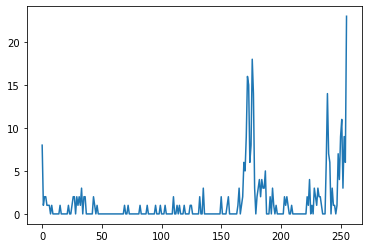

In [263]:
plt.plot(kw_data['강원'])

In [258]:
#kw_data = kw_data.drop(['구분별'], axis = 1)

In [259]:
#plt.bar(kw_data['시점'], kw_data['인원[명]']) # 서울 지역 확진자 날짜별 확인 

## ARIMA

In [260]:
!pip install pmdarima

In [261]:
# 예측 알고리즘 사용하여 시각화 
## 1. ARIMA
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima_model import ARIMA

def forecast_line(df,column):
    model=auto_arima(df[column],suppress_warnings=True)
    p,d,q = model.order
    
    if model.order == (0,0,0):
        p = 1
    elif p*q != 0:# AR 모형(회귀선 도출) 주로 활용
        q = 0
    else:
        pass
    
    n=int(df.shape[0]*0.8)
    train=df[:n]
    test=df[n:]
    model=ARIMA(train[column], order=(p,d,q)).fit()

    fc,se,conf=model.forecast(steps=len(test))
    fc_series=pd.Series(fc, index=test.index)    

    lower=pd.Series(conf[:,0], index=test.index) #하한값
    upper=pd.Series(conf[:,1], index=test.index) #상한값
    plt.figure(figsize=(12,5),dpi=100)
    plt.plot(df[column], label='Actuals') #실제값
    plt.plot(fc_series, label='Forecast') #예측값
    
    # 예측값의 구간
    plt.fill_between(lower.index, lower, upper, alpha=0.15)
    plt.legend(loc='upper left', fontsize=8)
    plt.show()

In [262]:
#kw_data = kw_data.fillna(0)

In [339]:
#forecast_line(kw_data,'강원') 

In [268]:
# 자기회귀누적이동평균모형(ARIMA(p,d,q) 모형)
model=auto_arima(kw_data['강원'],suppress_warnings=True)
model
# 최적값 4,0,1 ARMA(p,q)모형 정상성을 만족

ARIMA(maxiter=50, method='lbfgs', order=(2, 1, 3), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(0, 0, 0, 0),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=False)

In [269]:
#학습용,검증용 구분
n=int(kw_data.shape[0]*.8)
train=kw_data[:n]
test=kw_data[n:]

In [270]:
train.head()

,시점,강원
0,2020. 03. 02,8
1,2020. 03. 04,1
2,2020. 03. 05,2
3,2020. 03. 06,2
4,2020. 03. 07,1


In [272]:
model=ARIMA(kw_data['강원'], order=(4,0,1)).fit()

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 44053 missing from current font.

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 50896 missing from current font.

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 44053 missing from current font.

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning:

Glyph 50896 missing from current font.



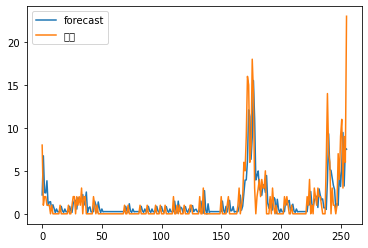

In [273]:
model.plot_predict()
plt.show()

## FBP

In [275]:
# 필요한 데이터 구성 
# 날짜와, 일일 확진자 수 / 칼럼을 ds,y 지정
import logging
logging.getLogger('fbprophet').setLevel(logging.WARNING)

In [276]:
kw_data.head()

,시점,강원
0,2020. 03. 02,8
1,2020. 03. 04,1
2,2020. 03. 05,2
3,2020. 03. 06,2
4,2020. 03. 07,1


In [277]:
# FBP 모델에 넣기 위한 데이터 가공
kw_data.columns = ['ds','y']

In [279]:
#Prophet 라이브러리를 사용한 예측
#유연성, 변형성 =0

from fbprophet import Prophet
from fbprophet.plot import plot_plotly, add_changepoints_to_plot
import logging

m=Prophet(
    yearly_seasonality=False,
    weekly_seasonality=True,
    daily_seasonality=True,
    seasonality_mode='additive'
)
m.fit(kw_data)

In [280]:
# 예측할 미래 dataframe 만들기 
future = m.make_future_dataframe(periods=10)
forecast = m.predict(future)

In [281]:
# 예측값 yhat 0 이하 인덱스 0으로 변경
idx=forecast[forecast['yhat_upper']<0].index
forecast.loc[idx, 'yhat_upper']=0
forecast1=forecast

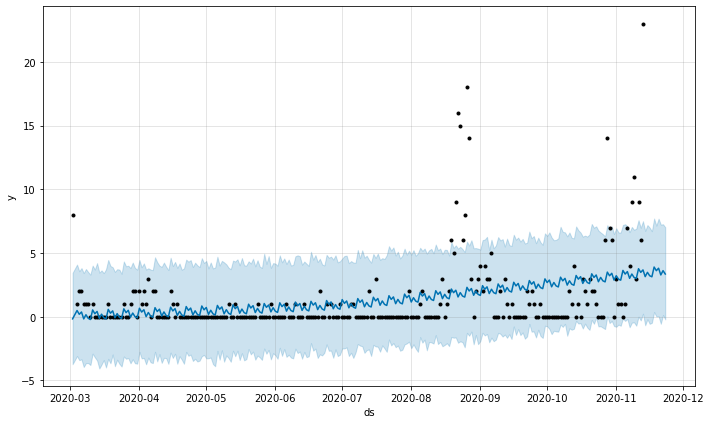

In [282]:
# 파란색 실선: 코로나 예상 환자
# 검은색 점 : 실제 환자
m.plot(forecast1);

검은색 점들이 이달의 환자들을 나타내고 파랑색 석은 그 추세를 보여준다. prophet를 통해 확인해보면 오차범위가 생각보다 크다는 것을 알 수가 있다. 

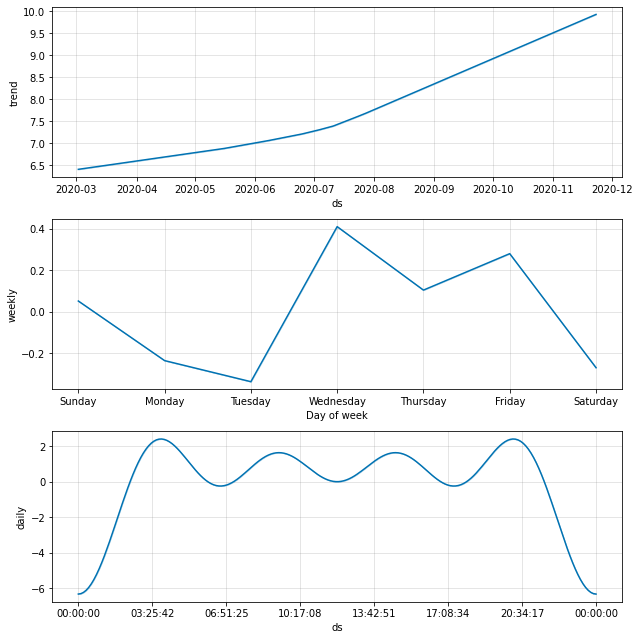

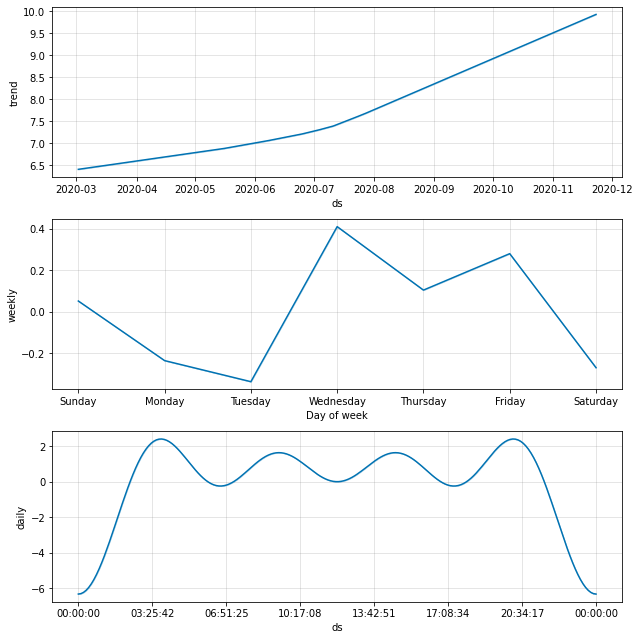

In [283]:
#forecast component를 시각화해준다(Trend, Weakly, Yearly)
#trend는 경향성을 보여주고 weekly는 한 주의 일별 경향을 보여준다
m.plot_components(forecast1)

In [284]:
#Prophet에선 기본적으로 트렌드가 변경되는 지점을 자동으로 감지해 트렌드를 예측해준다.
m = Prophet(
    changepoint_prior_scale=0.24, #Change Point의 유연성을 조정하는 방법: 디폴트는 0.05(값이 커질수록 유연해진다)
    changepoint_range=0.9, # 변환점 기본적으로 Prophet은 시계열 데이터의 80% 크기에서 잠재적으로 ChangePoint를 지정해주지만 90%로 설정해준다.
#     yearly_seasonality=False,
#     weekly_seasonality=False,
#     daily_seasonality=True,
#     seasonality_mode='additive'
)
m.fit(kw_data)

changepoint_prior_scale, changepoint_range 유연성과 변환점 값을 임의로 설정하여 넣고 미래 시계열 데이터를 확인한다. 

In [285]:
#미래 dataframe
future = m.make_future_dataframe(periods=30) #현재까지의 날짜로부터 30일의 미래
forecast2 = m.predict(future)

In [286]:
# 시각화 
## 점이 없이 선만 있는 부분이 예측된 미래
fig = plot_plotly(m, forecast2)
py.iplot(fig)

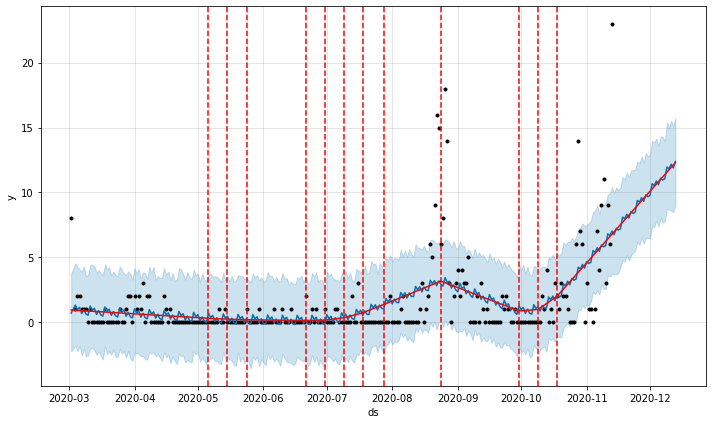

In [287]:
#checkpoints 나타내기
fig = m.plot(forecast2)
a = add_changepoints_to_plot(fig.gca(), m, forecast2)
#빨간 점선이 changepoints, 빨간 실선이 Trend를 나타낸다

changepoint_prior_scale를 0.05(default)가 아닌 0.24로 설정한 것은 데이터가 짧은 기간동안의 데이터이며 local mean을 보이지 않는 비정상 모형이기 때문에 예측에 유연성을 증가

changepoint_range를 0.8(default)이 아닌 0.9로 한 것은 데이터의 수가 적기때문에 데이터 하나의 값에 영향을 크게 받을 것이라고 판단해 더 많은 범위의 데이터를 회귀모형을 만드는 데이터셋에 넣고자 함

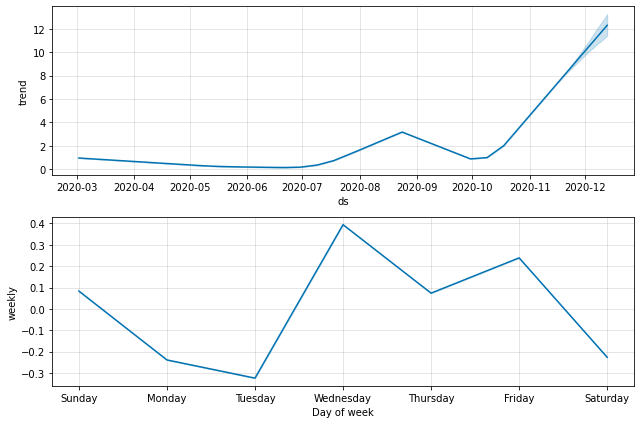

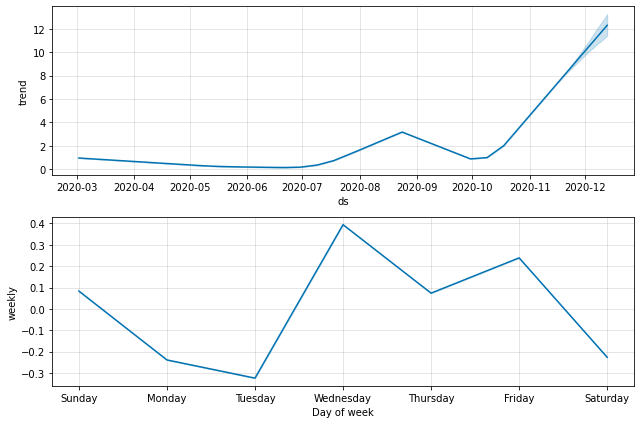

In [288]:
# 회귀 모형으로 확인 
m.plot_components(forecast2)

In [289]:
forecast2.date = pd.to_datetime(forecast2.ds)
#forecast1 대신 forecast2 사용
forecast2=forecast2.loc[:,['ds','yhat']]
forecast2=forecast2.set_index('ds')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning:

Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access



## RNN으로 예측


In [326]:
from keras.layers import LSTM, Dense, Bidirectional, Dropout
from keras.models import Sequential, Input
from keras.callbacks import EarlyStopping

In [314]:
kw_data.tail()

,ds,y
251,2020. 11. 09,11
252,2020. 11. 10,3
253,2020. 11. 11,9
254,2020. 11. 12,6
255,2020. 11. 13,23


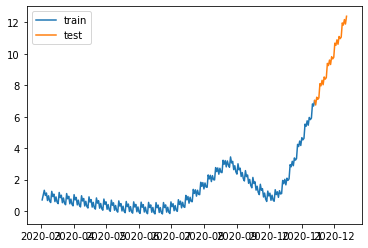

In [292]:
#자료를 섞지 않고 특정 시점을 기준으로 학습용,검증용을 구분
#split_data=pd.Timestamp('06-30-2020')
split_data=pd.Timestamp('2020. 11. 13')
train=forecast2.loc[:split_data, ['yhat']] #학습용 
test=forecast2.loc[split_data:, ['yhat']] #검증용
ax=plt.plot(train)
plt.plot(test)
plt.legend(['train','test'])

In [293]:
from sklearn.preprocessing import MinMaxScaler
sc=MinMaxScaler()
sc.fit(train)
train_sc=sc.transform(train)
test_sc=sc.transform(test)
#넘파이배열을 데이터프레임으로 변환
train_sc_df=pd.DataFrame(train_sc, columns=['Scaled'], index=train.index)
test_sc_df=pd.DataFrame(test_sc, columns=['Scaled'], index=test.index)

In [294]:
# 훈련, 테스트 데이터로 구분
for s in range(1,11):
    train_sc_df['shift_{}'.format(s)] = train_sc_df['Scaled'].shift(s)
    test_sc_df['shift_{}'.format(s)] = test_sc_df['Scaled'].shift(s)

In [295]:
#결측값 제거
X_train=train_sc_df.dropna().drop('Scaled',axis=1)
y_train=train_sc_df.dropna()[['Scaled']]
X_test=test_sc_df.dropna().drop('Scaled',axis=1)
y_test=test_sc_df.dropna()[['Scaled']]

In [296]:
#넘파이배열로 저장
X_train=X_train.values
X_test=X_test.values
y_train=y_train.values
y_test=y_test.values

In [297]:
#keras 신경망에 입력하기 위하여 3차원으로 변경
#  샘플수, timestep
X_train_t=X_train.reshape(X_train.shape[0],10,1)
X_test_t=X_test.reshape(X_test.shape[0],10,1)

In [334]:
model=Sequential()
# 순환계층, 출력노드 20개, timestep 12
model.add(Bidirectional(LSTM(256, input_shape=(12,1))))
model.add(Dense(1))  #출력층, 활성화함수는 linear
model.compile(loss='mean_squared_error',optimizer='adam')
model.fit(X_train_t, y_train, epochs=200, batch_size=30)

Epoch 1/200
9/9 [==============================] - 0s 48ms/step - loss: 0.0190
Epoch 2/200
9/9 [==============================] - 0s 45ms/step - loss: 0.0066
Epoch 3/200
9/9 [==============================] - 0s 46ms/step - loss: 0.0041
Epoch 4/200
9/9 [==============================] - 0s 46ms/step - loss: 0.0041
Epoch 5/200
9/9 [==============================] - 0s 47ms/step - loss: 0.0034
Epoch 6/200
9/9 [==============================] - 0s 45ms/step - loss: 0.0031
Epoch 7/200
9/9 [==============================] - 0s 46ms/step - loss: 0.0031
Epoch 8/200
9/9 [==============================] - 0s 47ms/step - loss: 0.0031
Epoch 9/200
9/9 [==============================] - 0s 45ms/step - loss: 0.0030
Epoch 10/200
9/9 [==============================] - 0s 47ms/step - loss: 0.0027
Epoch 11/200
9/9 [==============================] - 0s 46ms/step - loss: 0.0026
Epoch 12/200
9/9 [==============================] - 0s 47ms/step - loss: 0.0025
Epoch 13/200
9/9 [==============================]

In [335]:
## prediction check 
y_pred=model.predict(X_test_t)
print(y_pred[:5])

In [336]:
result = model.evaluate(X_test_t, y_test)

1/1 [==============================] - 0s 3ms/step - loss: 0.0010


In [337]:
result

0.0010427824454382062

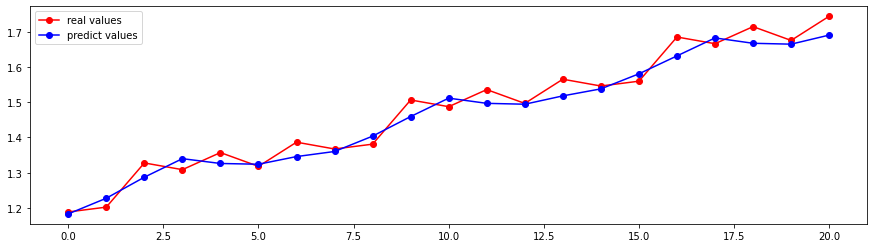

In [338]:
%matplotlib inline
fig=plt.figure(figsize=(15,4))
plt.plot(y_test.flatten(), 'ro-', label='real values')
plt.plot(y_pred.flatten(), 'bo-', label='predict values')
plt.legend()